In [1]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
from datetime import datetime
import salem
import math
from salem import *

In [2]:
fl_path = '/home/pelto/Desktop/ice_flux/Conrad/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/conrad/'
vdir ='img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/'
vdir1 = '/home/pelto/Desktop/velocity_mapping/Conrad_DEMs/spm2/' + vdir
path = '/media/pelto/serac_backup/Lidar_DEMs/bare_earth_BC_hydro/conrad/'


In [3]:
f_in = 'conrad_stakes.csv'    
stakes = pd.read_csv('/home/pelto/Desktop/ice_flux/Conrad/' + f_in)
stakes[0:10]

,survey_no,year,date,name,new_old,surv_name,E,N,Elev
0,1,2015,2015-07-16,NaN,NaN,CONK2,505177.5,5631146.0,1889.4
1,1,2015,2015-07-16,NaN,NaN,CONKJ,504922.8,5630804.0,2022.4
2,1,2015,2015-07-16,CST2,new,CONK3,505188.8,5630627.0,2077.3
3,1,2015,2015-07-16,NaN,NaN,CONKWX,505460.7,5630350.0,2125.8
4,1,2015,2015-07-16,NaN,NaN,CONKWX2,505544.5,5630157.0,2148.2
5,1,2015,2015-07-16,NaN,NaN,CONKIN,505215.9,5629867.0,2209.1
6,1,2015,2015-07-16,NaN,NaN,CONKINK,505278.0,5629838.0,2206.0
7,1,2015,2015-07-16,CST3,old,CONKINK3,505542.8,5629937.0,2177.8
8,1,2015,2015-07-16,CST3,new,CONKINK3A,505544.7,5629931.0,2181.7
9,1,2015,2015-07-16,NaN,NaN,CONKINKJ,505475.7,5630744.0,2089.4


In [4]:
Dis=pd.DataFrame({})
for num in np.arange(2,7,1):  
    T=np.array(stakes[(stakes.survey_no==num)&(stakes.new_old=='old')].name) ##add in 'both'
    for n in T:
        try:
            x=stakes[(stakes.survey_no==num-1) & (stakes.name==n) & (stakes.new_old=='new')].index[0] ##add in 'both'
        except:
            continue
        else:
            G=stakes[stakes.index==x]
            if np.array(G.new_old=='new')[0]:
                eNEW=float(G.E)
                nNEW=float(G.N)
                
                eOLD=float(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].E)
                nOLD=float(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].N)
                
                ##calculate stake displacement (meters) 
                distance = np.sqrt((eNEW - eOLD)**2 + (nNEW - nOLD)**2)
                dist_x = eOLD - eNEW  
                dist_y = nOLD - nNEW  
              
                
                ##calculate time (days) between surveys and then velocity (m/yr)
                start_DATE = (stakes[(stakes.name==n) & (stakes.survey_no==num-1)&(stakes.new_old=='new')].date)
                end_DATE   = (stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].date)
                S_DT=datetime.strptime(np.array(start_DATE)[0],'%Y-%m-%d')
                E_DT=datetime.strptime(np.array(end_DATE)[0],'%Y-%m-%d')
                diff_days  = (E_DT - S_DT).days 
                V = float((distance / diff_days) * 365.)
                
                u = float((dist_x / diff_days) * 365.) 
                v = float((dist_y / diff_days) * 365.) 

                ##calculate azimuth  
    #           https://gis.stackexchange.com/questions/108547/how-to-calculate-distance-azimuth-and-dip-from-two-xyz-coordinates
                az = math.degrees(math.atan2((eOLD - eNEW), (nOLD - nNEW))) 
                         
                Ele=float(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].Elev)
                year=int(stakes[(stakes.name==n) & (stakes.survey_no==num)&(stakes.new_old=='old')].year)
                
                Dis=Dis.append({'Name':n,'eNew':(eNEW), 'nNew':(nNEW),'eOld':(eOLD),'nOld':(nOLD),
                                'Elevation':Ele,'Year':year, 'Displacement':distance,'time_days':diff_days, 
                                'velocity':V, 'azimuth': az, 'u':u, 'v':v}, ignore_index=True)
Dis                

,Displacement,Elevation,Name,Year,azimuth,eNew,eOld,nNew,nOld,time_days,u,v,velocity
0,3.047950,1876.8,CST0,2015.0,48.990913,505139.8,505142.100,5631227.0,5631229.000,52.0,16.144231,14.038462,21.394265
1,6.621178,1968.0,CST1,2015.0,25.016893,504987.4,504990.200,5630982.0,5630988.000,52.0,19.653846,42.115385,46.475577
2,3.720215,2073.4,CST2,2015.0,-36.253838,505188.8,505186.600,5630627.0,5630630.000,52.0,-15.442308,21.057692,26.113048
3,11.605602,2174.6,CST3,2015.0,-18.591068,505544.7,505541.000,5629931.0,5629942.000,52.0,-25.971154,77.211538,81.462399
4,11.605602,1964.7,CST1,2016.0,18.591068,504991.1,504994.800,5630988.0,5630999.000,288.0,4.689236,13.940972,14.708489
5,5.381450,1874.8,CST0,2016.0,41.987212,505142.6,505146.200,5631227.0,5631231.000,288.0,4.562500,5.069444,6.820240
6,25.663983,2172.9,CST3,2016.0,-13.061551,505540.9,505535.100,5629941.0,5629966.000,288.0,-7.350694,31.684028,32.525533
7,1.220656,1871.1,CST0,2016.0,34.992020,505139.4,505140.100,5631225.0,5631226.000,70.0,3.650000,5.214286,6.364847
8,3.440930,2071.1,CST2A,2016.0,-54.462322,504995.0,504992.200,5630419.0,5630421.000,70.0,-14.600000,10.428571,17.941993
9,4.534314,2071.3,CST2B,2016.0,-48.576334,505077.6,505074.200,5630522.0,5630525.000,70.0,-17.728571,15.642857,23.643207


In [5]:
def flux_gate_velocity(vdir, msk, gates):  #, gates, points)#, be_dem, snow_dem, msk):
    # open GeoTIFF as array
#    msk='conrad_2016_ice_msk_5m_glacieronly.tif'
    VX = vdir1 + vdir[:-1] + '-F_vx.tif' 
    VY = vdir1+ vdir[:-1] + '-F_vy.tif' 
    vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
    vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
    msk = salem.open_xr_dataset(path+ msk) 
    msk = msk.to_array()
    
#     pts = salem.read_shapefile(fl_path+pts)
    gates = salem.read_shapefile(fl_path+gates)
#     msk[msk == 0.0] = 2.0
#     msk[msk == 1.0] = np.nan

    vx = vx.to_array(name=xvel)
    vy = vy.to_array(name=yvel)
    
    vx.data[msk.data==0] = np.nan
    vy.data[msk.data==0] = np.nan
    
    #     # map extent
    grid = mercator_grid(center_ll=(-116.94, 50.80), extent=(10000, 9000))
    #     grid = vx.salem.grid
    sm = Map(grid, countries=False)
    sm.set_lonlat_contours(interval=0)
    sm.set_scale_bar()
    sm.set_data(vx)
    #      Change the lon-lat countour setting
    sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
    
    
    shpf = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_all_glaciers_2014.shp'
    gdf = salem.read_shapefile(shpf)
    sm.set_shapefile(gdf, linewidth=1)
    sm.set_shapefile(gates, linewidth=1.5, color='r')
    sm.visualize()
    plt.show()

    fig, ax = plt.subplots()
    X = vx.x
    print(vx.x)
    Y = vy.y
    U = vx.data
    V = vy.data
    Q = ax.quiver(X, Y, U, V, units='xy', angles='uv')

    
    
    return vx

In [6]:
# velX = flux_gate_velocity(vdir, 'conrad_2016_ice_msk_5m_glacieronly.tif', 'conrad_flux_gates_17.shp')
# 'conrad_points_17gates.shp')

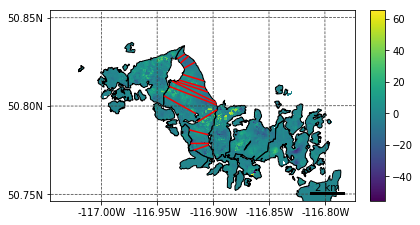

In [7]:
gates = 'conrad_flux_gates_17.shp'
points = fl_path + 'conrad_points_17gates_20m_b.shp' #'conrad_points_17gates.shp'
msk='conrad_2016_ice_msk_5m_glacieronly.tif'

# open GeoTIFF as array
#    msk='conrad_2016_ice_msk_5m_glacieronly.tif'
VX = vdir1 + vdir[:-1] + '-F_vx.tif' 
VY = vdir1+ vdir[:-1] + '-F_vy.tif' 
vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
msk = salem.open_xr_dataset(path+ msk) 
msk = msk.to_array(name='msk')
gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_25_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
# H_opt = salem.GeoNetcdf(opt_path + 'Conrad101sw_MAE_optimized.nc')
H_opt = salem.open_xr_dataset(fl_path + 'opt_thick_101sw_MAE_5m.tif') #'Conrad101sw_MAE_optimized.nc'
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(fl_path+gates)
topo = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/20160912_conrad_dem1_clip_slave.tif'
dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')


vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
gpr = gpr.to_array(name='gpr')
H_opt = H_opt.to_array(name='H_opt')


# ptsID.data[ptsID.data<-1000] = np.nan
# pts_ras.data[pts_ras.data<-1000] = np.nan
gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data==1.000] == 0.0   #not having any effect
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan



#     # map extent
# grid = mercator_grid(center_ll=(-116.94, 50.80), extent=(10000, 9000)) ##zoomed out view
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vx)

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')


shpf = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_all_glaciers_2014.shp'
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.show()

In [8]:
len(gpr.data[gpr.data==0.000])

0

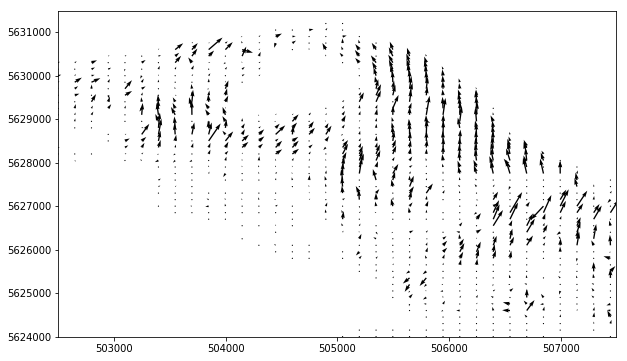

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,6))


df = salem.read_shapefile(fl_path + 'conrad_points_17gates_20m_wgs84_b.shp')

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]


xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);


X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
ax.set_xlim(502500, 507500)
ax.set_ylim( 5624000, 5631500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/'+ 'conrad_16_17_quiver.pdf', dpi=300)

In [10]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem',
       ]

In [11]:
vns

['vx', 'vy', 'gpr', 'H_opt', 'dem']

In [12]:
M = xr.merge([vx,vy,gpr,H_opt, dem])

In [13]:
M.gpr.mean()

<xarray.DataArray 'gpr' ()>
array(130.14337, dtype=float32)

In [14]:
for vn in vns:
    Dis[vn] = M[vn][0].interp(x=('z', Dis.eNew), y=('z', Dis.nNew))

In [15]:
Dis

,Displacement,Elevation,Name,Year,azimuth,eNew,eOld,nNew,nOld,time_days,u,v,velocity,vx,vy,gpr,H_opt,dem
0,3.047950,1876.8,CST0,2015.0,48.990913,505139.8,505142.100,5631227.0,5631229.000,52.0,16.144231,14.038462,21.394265,-4.772811,2.723495,NaN,20.772923,1883.163975
1,6.621178,1968.0,CST1,2015.0,25.016893,504987.4,504990.200,5630982.0,5630988.000,52.0,19.653846,42.115385,46.475577,2.862153,2.496104,58.150002,47.749821,1980.203983
2,3.720215,2073.4,CST2,2015.0,-36.253838,505188.8,505186.600,5630627.0,5630630.000,52.0,-15.442308,21.057692,26.113048,-12.527554,16.516147,78.430000,81.561424,2085.642090
3,11.605602,2174.6,CST3,2015.0,-18.591068,505544.7,505541.000,5629931.0,5629942.000,52.0,-25.971154,77.211538,81.462399,-3.927640,36.931221,NaN,152.328259,2188.042586
4,11.605602,1964.7,CST1,2016.0,18.591068,504991.1,504994.800,5630988.0,5630999.000,288.0,4.689236,13.940972,14.708489,2.975105,2.094558,NaN,47.749821,1978.030037
5,5.381450,1874.8,CST0,2016.0,41.987212,505142.6,505146.200,5631227.0,5631231.000,288.0,4.562500,5.069444,6.820240,-4.316740,2.666314,NaN,20.685944,1882.666979
6,25.663983,2172.9,CST3,2016.0,-13.061551,505540.9,505535.100,5629941.0,5629966.000,288.0,-7.350694,31.684028,32.525533,-4.464040,35.765913,NaN,153.571793,2186.615278
7,1.220656,1871.1,CST0,2016.0,34.992020,505139.4,505140.100,5631225.0,5631226.000,70.0,3.650000,5.214286,6.364847,-4.236425,2.401400,NaN,20.801917,1883.714424
8,3.440930,2071.1,CST2A,2016.0,-54.462322,504995.0,504992.200,5630419.0,5630421.000,70.0,-14.600000,10.428571,17.941993,-5.323493,6.100126,101.226003,56.938904,2085.390723
9,4.534314,2071.3,CST2B,2016.0,-48.576334,505077.6,505074.200,5630522.0,5630525.000,70.0,-17.728571,15.642857,23.643207,-3.286112,0.275739,108.769997,102.996040,2085.345818


In [16]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [17]:
df

,ID,length,distance,angle,geometry,min_x,max_x,min_y,max_y,lon,lat,x,y,vx,vy,gpr,H_opt,dem
0,2,782.252,0.000,61.368576,POINT (-116.9259650308174 50.82143882883324),-116.925965,-116.925965,50.821439,50.821439,-116.925965,50.821439,505214.918200,5.629971e+06,NaN,NaN,NaN,59.788406,2167.061996
1,2,782.252,20.000,61.368576,POINT (-116.925715678521 50.82152485234388),-116.925716,-116.925716,50.821525,50.821525,-116.925716,50.821525,505232.472606,5.629981e+06,-2.440528,5.582760,NaN,59.788406,2157.262762
2,2,782.252,40.000,61.368576,POINT (-116.9254663253086 50.82161087532001),-116.925466,-116.925466,50.821611,50.821611,-116.925466,50.821611,505250.027012,5.629990e+06,-3.910453,8.886530,NaN,59.788406,2163.926460
3,2,782.252,60.000,61.368576,POINT (-116.9252169711804 50.8216968977616),-116.925217,-116.925217,50.821697,50.821697,-116.925217,50.821697,505267.581418,5.630000e+06,-3.811575,9.242476,NaN,72.055252,2170.808008
4,2,782.252,80.000,61.368576,POINT (-116.9249676161363 50.82178291966868),-116.924968,-116.924968,50.821783,50.821783,-116.924968,50.821783,505285.135824,5.630009e+06,-5.026195,14.856584,79.110001,121.214302,2170.126704
5,2,782.252,100.000,61.368576,POINT (-116.9247182601763 50.8218689410412),-116.924718,-116.924718,50.821869,50.821869,-116.924718,50.821869,505302.690231,5.630019e+06,-3.896853,11.516027,87.209999,121.214302,2166.719127
6,2,782.252,120.000,61.368576,POINT (-116.9244689033004 50.82195496187919),-116.924469,-116.924469,50.821955,50.821955,-116.924469,50.821955,505320.244637,5.630029e+06,-5.585371,15.484585,100.368373,121.214302,2162.745540
7,2,782.252,140.000,61.368576,POINT (-116.9242195455086 50.82204098218262),-116.924220,-116.924220,50.822041,50.822041,-116.924220,50.822041,505337.799043,5.630038e+06,-9.580359,24.195636,102.709999,121.214302,2159.426514
8,2,782.252,160.000,61.368576,POINT (-116.9239701868009 50.82212700195151),-116.923970,-116.923970,50.822127,50.822127,-116.923970,50.822127,505355.353449,5.630048e+06,-7.396264,18.165467,112.139999,121.214302,2157.139421
9,2,782.252,180.000,61.368576,POINT (-116.9237208271773 50.82221302118582),-116.923721,-116.923721,50.822213,50.822213,-116.923721,50.822213,505372.907855,5.630057e+06,-10.844764,26.682447,120.220001,121.214302,2156.611467


In [18]:
# grid.ij_coordinates
# v_crs = check_crs(vx)
# v_crs

In [19]:
df_agg = df[['ID', 'length', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [20]:
v_crs = check_crs(vx)
v_crs

<salem.Grid>
  proj: +init=epsg:32611 +units=m
  pixel_ref: center
  origin: upper-left
  (nx, ny): (3842, 2402)
  (dx, dy): (5.0, -5.0)
  (x0, y0): (496796.0, 5633604.0)

In [30]:
# df_dis = Dis.copy()
# ii, jj = grid.transform(df_dis.eNew, df_dis.nNew, crs=v_crs, nearest=True) #salem.wgs84
# df_dis['i'] = ii
# df_dis['j'] = jj
# # # We trick by creating an index of similar i's and j's
# # df_dis['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
# df_dis['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
# df_dis = df_dis.groupby('ij').mean()
# # # Select
# for vn in vns:
#     df_dis[vn] = M[vn][0].isel(x=('z', df_dis.i), y=('z', df_dis.j))
# for vn in vns:
#     Dis[vn] = M[vn][0].isel(x=('z', Dis.eNew), y=('z', Dis.nNew))

In [31]:
Dis

,Displacement,Elevation,Name,Year,azimuth,eNew,eOld,nNew,nOld,time_days,u,v,velocity,vx,vy,gpr,H_opt,dem
0,3.047950,1876.8,CST0,2015.0,48.990913,505139.8,505142.100,5631227.0,5631229.000,52.0,16.144231,14.038462,21.394265,-4.772811,2.723495,NaN,20.772923,1883.163975
1,6.621178,1968.0,CST1,2015.0,25.016893,504987.4,504990.200,5630982.0,5630988.000,52.0,19.653846,42.115385,46.475577,2.862153,2.496104,58.150002,47.749821,1980.203983
2,3.720215,2073.4,CST2,2015.0,-36.253838,505188.8,505186.600,5630627.0,5630630.000,52.0,-15.442308,21.057692,26.113048,-12.527554,16.516147,78.430000,81.561424,2085.642090
3,11.605602,2174.6,CST3,2015.0,-18.591068,505544.7,505541.000,5629931.0,5629942.000,52.0,-25.971154,77.211538,81.462399,-3.927640,36.931221,NaN,152.328259,2188.042586
4,11.605602,1964.7,CST1,2016.0,18.591068,504991.1,504994.800,5630988.0,5630999.000,288.0,4.689236,13.940972,14.708489,2.975105,2.094558,NaN,47.749821,1978.030037
5,5.381450,1874.8,CST0,2016.0,41.987212,505142.6,505146.200,5631227.0,5631231.000,288.0,4.562500,5.069444,6.820240,-4.316740,2.666314,NaN,20.685944,1882.666979
6,25.663983,2172.9,CST3,2016.0,-13.061551,505540.9,505535.100,5629941.0,5629966.000,288.0,-7.350694,31.684028,32.525533,-4.464040,35.765913,NaN,153.571793,2186.615278
7,1.220656,1871.1,CST0,2016.0,34.992020,505139.4,505140.100,5631225.0,5631226.000,70.0,3.650000,5.214286,6.364847,-4.236425,2.401400,NaN,20.801917,1883.714424
8,3.440930,2071.1,CST2A,2016.0,-54.462322,504995.0,504992.200,5630419.0,5630421.000,70.0,-14.600000,10.428571,17.941993,-5.323493,6.100126,101.226003,56.938904,2085.390723
9,4.534314,2071.3,CST2B,2016.0,-48.576334,505077.6,505074.200,5630522.0,5630525.000,70.0,-17.728571,15.642857,23.643207,-3.286112,0.275739,108.769997,102.996040,2085.345818


In [33]:
D = df_agg[['ID', 'length', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt']].copy()
D

KeyError: "['gpr', 'vx', 'H_opt', 'vy'] not in index"

In [34]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north


### calculate angle of flux gate
#try making a raster with footprint of vel. raster with FG angle as the value
# FG_alpha = pts_ras.data - 90.0 # calculate normal angle to flux gate 

#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice
D['Qopt'] = D.vfg * 0.9 * 20. * D.H_opt     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a'] = 20. * D.H_opt #area per slice

NameError: name 'D' is not defined

In [36]:
import math
Dis['vz'] = np.sqrt(Dis.vx**2 + Dis.vy**2 )  # np.sqrt(U**2 + V**2 )

Dis['vzdir'] = np.arcsin(Dis.vx/Dis.vz) *180/math.pi #Disegrees from north


### calculate angle of flux gate
#try making a raster with footprint of vel. raster with FG angle as the value
# FG_alpha = pts_ras.Disata - 90.0 # calculate normal angle to flux gate 

#multiply velocity vector by cosine of angle between vector anDis flux gate (line or line segment)
# Dis['vfg'] = np.abs(Dis.vz * np.cos((Dis.vzdir-(Dis.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice
# Dis['Qopt'] = Dis.vfg * 0.9 * 20. * Dis.H_opt     ## ice flux per slice *0.9 to est. Disepth-integrateDis velocity
# Dis['a'] = 20. * Dis.H_opt #area per slice

In [42]:
comp

,velocity,vz,Year,diff_vel
0,21.394265,5.495194,2015.0,15.899072
1,NaN,3.797691,2015.0,NaN
2,26.113048,20.729754,2015.0,5.383293
3,NaN,37.139486,2015.0,NaN
4,14.708489,3.638465,2016.0,11.070024
5,6.820240,5.073803,2016.0,1.746437
6,32.525533,36.043421,2016.0,-3.517888
7,6.364847,4.869704,2016.0,1.495143
8,17.941993,8.096364,2016.0,9.845629
9,23.643207,3.297661,2016.0,20.345546


In [48]:
comp.diff_vel[comp.Year==float(year)]

39     6.901717
40    -3.159403
41    10.372737
42    -2.412377
43     0.323507
44    16.357776
45    -0.928210
46    20.064131
47     7.502326
48     4.074755
49   -13.772003
50     5.042547
Name: diff_vel, dtype: float64

In [41]:
comp = Dis[['velocity', 'vz','Year']].copy()
comp.velocity[comp.velocity>45.]= np.nan ## remove outliers
comp['diff_vel'] =  comp.velocity - comp.vz

# pd.DataFrame(columns=['stake_vel', 'vel_ftr'], data=[Dis.velocity, Dis.vz])
                                                

In [46]:
mean = comp.diff_vel[comp.Year==float(year)].mean()
std  = comp.diff_vel.std()
print(mean, '+/-',std)

4.197291996784929 +/- 9.403909038497696


In [39]:
len(comp)

51

In [180]:
D.vzdir[D.ID==0].mean()

-14.486448287963867

In [181]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]

for n in range(D.ID.nunique()+1):
        Q_out.append(D.Qopt[D.ID==n].sum()) 
        cr_area.append(D.a[D.ID==n].sum())
        vzdir.append(D.vzdir[D.ID==n].mean())           
Q_in = [Q_out[1:]] #flux in per bin
Q_in = np.squeeze(Q_in)
# Q_in[]



FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, vzdir)), columns=['Q_out', 'Q_in', 'cr_area', 'vzdir']) 

FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['bin']=np.arange(0,12,1)
FG

,Q_out,Q_in,cr_area,vzdir,vfg,bin
0,0.000000e+00,3.450211e+05,0.000000,0.000000,NaN,0
1,3.450211e+05,1.135416e+06,33513.510056,-14.486448,10.294985,1
2,1.135416e+06,2.313451e+06,64269.293289,-31.015211,17.666532,2
3,2.313451e+06,3.529334e+06,107624.749756,-21.845184,21.495533,3
4,3.529334e+06,3.912141e+06,158754.289856,4.446336,22.231425,4
5,3.912141e+06,1.213015e+07,276697.371063,8.616990,14.138698,5
6,1.213015e+07,1.122418e+06,592639.663467,10.568986,20.468006,6
7,1.122418e+06,1.259106e+06,131967.269287,15.551443,8.505272,7
8,1.259106e+06,2.815964e+06,133286.139526,3.720243,9.446640,8
9,2.815964e+06,3.632632e+05,142157.660217,25.009708,19.808741,9


In [182]:
data = pd.read_csv(fl_path + 'Conrad_bins_17b.csv') #need dh_dt, area, field pts, n, mid elev (mean elev)
data.sort_values(by=['bin'],ascending=True, inplace=True) # sort by bin
data.set_index('bin', inplace=True) # set bin as index for sorting
data[0:4]

,area,elevmean,elevmedian,dh1617mean,dh1617medi,dh1617stde,v1617smean,v1617smedi,b_obs,rho
bin,,,,,,,,,,
0,187285.170550,1998.672562,2015.614441,-4.818590,-4.237488,2.452925,7.304257,6.291698,-5.53,910
1,169672.030467,2079.702626,2080.632080,-3.016451,-3.011963,0.821474,13.608355,13.330932,-5.04,910
2,336995.972514,2127.595726,2127.915283,-2.766704,-2.727051,0.739795,21.354307,24.717483,-4.40,910
3,818088.475361,2215.651550,2207.628418,-2.339868,-2.250244,0.868124,23.810894,26.078661,-3.98,910


In [183]:
FG_df =  pd.concat([FG, data], axis=1)
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,elevmean,elevmedian,dh1617mean,dh1617medi,dh1617stde,v1617smean,v1617smedi,b_obs,rho
0,0.000000e+00,3.450211e+05,0.000000,0.000000,NaN,0,1.872852e+05,1998.672562,2015.614441,-4.818590,-4.237488,2.452925,7.304257,6.291698,-5.53,910
1,3.450211e+05,1.135416e+06,33513.510056,-14.486448,10.294985,1,1.696720e+05,2079.702626,2080.632080,-3.016451,-3.011963,0.821474,13.608355,13.330932,-5.04,910
2,1.135416e+06,2.313451e+06,64269.293289,-31.015211,17.666532,2,3.369960e+05,2127.595726,2127.915283,-2.766704,-2.727051,0.739795,21.354307,24.717483,-4.40,910
3,2.313451e+06,3.529334e+06,107624.749756,-21.845184,21.495533,3,8.180885e+05,2215.651550,2207.628418,-2.339868,-2.250244,0.868124,23.810894,26.078661,-3.98,910
4,3.529334e+06,3.912141e+06,158754.289856,4.446336,22.231425,4,6.200832e+05,2317.819081,2310.515991,-1.567045,-1.465576,2.417679,27.175115,28.274642,-3.21,910
5,3.912141e+06,1.213015e+07,276697.371063,8.616990,14.138698,5,6.124855e+05,2413.444216,2402.900146,-1.289436,-1.223389,0.925775,21.967037,24.049708,-1.81,910
6,1.213015e+07,1.122418e+06,592639.663467,10.568986,20.468006,6,2.927177e+06,2554.705389,2549.165283,-0.962361,-0.987549,2.151822,18.853872,15.781603,0.06,850
7,1.122418e+06,1.259106e+06,131967.269287,15.551443,8.505272,7,1.501515e+06,2767.840472,2755.179932,-1.078800,-1.069580,2.192788,8.926504,6.736314,1.58,600
8,1.259106e+06,2.815964e+06,133286.139526,3.720243,9.446640,8,1.357701e+06,2814.849185,2814.723389,-1.214048,-1.239746,1.089671,22.576619,16.932728,0.61,600
9,2.815964e+06,3.632632e+05,142157.660217,25.009708,19.808741,9,8.178091e+05,2924.241596,2923.753906,-1.478586,-1.450684,0.586149,17.267177,15.381827,0.92,575


In [184]:
bb = FG_df.Q_out[6]+ FG_df.Q_out[7] - FG_df.Q_out[5]
bb

9340429.304856354

In [185]:
FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
# FG_df.Q_net[FG_df.bin==8] = FG_df.Q_out[FG_df.bin==9]+ FG_df.Q_out[FG_df.bin==10] - FG_df.Q_out[FG_df.bin==8]
FG_df.Q_net[6] = FG_df.Q_out[7]+ FG_df.Q_out[8] - FG_df.Q_out[6]
FG_df   #[0:4]

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,elevmean,elevmedian,dh1617mean,dh1617medi,dh1617stde,v1617smean,v1617smedi,b_obs,rho,Q_net
0,0.000000e+00,3.450211e+05,0.000000,0.000000,NaN,0,1.872852e+05,1998.672562,2015.614441,-4.818590,-4.237488,2.452925,7.304257,6.291698,-5.53,910,3.450211e+05
1,3.450211e+05,1.135416e+06,33513.510056,-14.486448,10.294985,1,1.696720e+05,2079.702626,2080.632080,-3.016451,-3.011963,0.821474,13.608355,13.330932,-5.04,910,7.903944e+05
2,1.135416e+06,2.313451e+06,64269.293289,-31.015211,17.666532,2,3.369960e+05,2127.595726,2127.915283,-2.766704,-2.727051,0.739795,21.354307,24.717483,-4.40,910,1.178036e+06
3,2.313451e+06,3.529334e+06,107624.749756,-21.845184,21.495533,3,8.180885e+05,2215.651550,2207.628418,-2.339868,-2.250244,0.868124,23.810894,26.078661,-3.98,910,1.215883e+06
4,3.529334e+06,3.912141e+06,158754.289856,4.446336,22.231425,4,6.200832e+05,2317.819081,2310.515991,-1.567045,-1.465576,2.417679,27.175115,28.274642,-3.21,910,3.828066e+05
5,3.912141e+06,1.213015e+07,276697.371063,8.616990,14.138698,5,6.124855e+05,2413.444216,2402.900146,-1.289436,-1.223389,0.925775,21.967037,24.049708,-1.81,910,8.218012e+06
6,1.213015e+07,1.122418e+06,592639.663467,10.568986,20.468006,6,2.927177e+06,2554.705389,2549.165283,-0.962361,-0.987549,2.151822,18.853872,15.781603,0.06,850,-9.748629e+06
7,1.122418e+06,1.259106e+06,131967.269287,15.551443,8.505272,7,1.501515e+06,2767.840472,2755.179932,-1.078800,-1.069580,2.192788,8.926504,6.736314,1.58,600,1.366886e+05
8,1.259106e+06,2.815964e+06,133286.139526,3.720243,9.446640,8,1.357701e+06,2814.849185,2814.723389,-1.214048,-1.239746,1.089671,22.576619,16.932728,0.61,600,1.556858e+06
9,2.815964e+06,3.632632e+05,142157.660217,25.009708,19.808741,9,8.178091e+05,2924.241596,2923.753906,-1.478586,-1.450684,0.586149,17.267177,15.381827,0.92,575,-2.452701e+06


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

In [186]:
fb= Q_in[5] - Q_out[5]
fb

8218011.744532753

In [187]:
FG_df['Q_netA']= FG_df.Q_net / FG_df.area 
FG_df['b_fg_h'] = FG_df.dh1617mean - FG_df.Q_netA
FG_df['b_fg_we'] = FG_df.rho/1000. * FG_df.b_fg_h
# FG_df.drop(FG_df.tail(1).index,inplace=True)
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,elevmean,elevmedian,dh1617mean,dh1617medi,dh1617stde,v1617smean,v1617smedi,b_obs,rho,Q_net,Q_netA,b_fg_h,b_fg_we
0,0.000000e+00,3.450211e+05,0.000000,0.000000,NaN,0,1.872852e+05,1998.672562,2015.614441,-4.818590,-4.237488,2.452925,7.304257,6.291698,-5.53,910,3.450211e+05,1.842223,-6.660813,-6.061340
1,3.450211e+05,1.135416e+06,33513.510056,-14.486448,10.294985,1,1.696720e+05,2079.702626,2080.632080,-3.016451,-3.011963,0.821474,13.608355,13.330932,-5.04,910,7.903944e+05,4.658366,-7.674817,-6.984084
2,1.135416e+06,2.313451e+06,64269.293289,-31.015211,17.666532,2,3.369960e+05,2127.595726,2127.915283,-2.766704,-2.727051,0.739795,21.354307,24.717483,-4.40,910,1.178036e+06,3.495697,-6.262401,-5.698785
3,2.313451e+06,3.529334e+06,107624.749756,-21.845184,21.495533,3,8.180885e+05,2215.651550,2207.628418,-2.339868,-2.250244,0.868124,23.810894,26.078661,-3.98,910,1.215883e+06,1.486248,-3.826116,-3.481766
4,3.529334e+06,3.912141e+06,158754.289856,4.446336,22.231425,4,6.200832e+05,2317.819081,2310.515991,-1.567045,-1.465576,2.417679,27.175115,28.274642,-3.21,910,3.828066e+05,0.617347,-2.184392,-1.987797
5,3.912141e+06,1.213015e+07,276697.371063,8.616990,14.138698,5,6.124855e+05,2413.444216,2402.900146,-1.289436,-1.223389,0.925775,21.967037,24.049708,-1.81,910,8.218012e+06,13.417479,-14.706915,-13.383293
6,1.213015e+07,1.122418e+06,592639.663467,10.568986,20.468006,6,2.927177e+06,2554.705389,2549.165283,-0.962361,-0.987549,2.151822,18.853872,15.781603,0.06,850,-9.748629e+06,-3.330386,2.368025,2.012822
7,1.122418e+06,1.259106e+06,131967.269287,15.551443,8.505272,7,1.501515e+06,2767.840472,2755.179932,-1.078800,-1.069580,2.192788,8.926504,6.736314,1.58,600,1.366886e+05,0.091034,-1.169834,-0.701900
8,1.259106e+06,2.815964e+06,133286.139526,3.720243,9.446640,8,1.357701e+06,2814.849185,2814.723389,-1.214048,-1.239746,1.089671,22.576619,16.932728,0.61,600,1.556858e+06,1.146687,-2.360735,-1.416441
9,2.815964e+06,3.632632e+05,142157.660217,25.009708,19.808741,9,8.178091e+05,2924.241596,2923.753906,-1.478586,-1.450684,0.586149,17.267177,15.381827,0.92,575,-2.452701e+06,-2.999112,1.520526,0.874303


In [188]:
D['Agpr']=np.NaN
for n in range(D.ID.nunique()+1):

    for c in range(D.ID[D.ID==n].count()-1):
        idx=D[(D.ID==n)&(D.distance==D[D.ID==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c] * D.gpr[D.ID==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.ID==n][c+1] - D.distance[D.ID==n][c])/2 * D.gpr[D.ID==n][c]
        elif c==len(D.ID[D.ID==n])-2: #
            G= (D.distance[D.ID==n][c] - D.distance[D.ID==n][c-1])/2 * D.gpr[D.ID==n]
        elif c==len(D.ID[D.ID==n])-1:  #last point in line
            G= D.distance[D.ID==n][c] + D.distance[D.ID==n][c+1] * D.gpr[D.ID==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.ID==n][c+1]-D.distance[D.ID==n][c])/2) + ((D.distance[D.ID==n][c] -
                    D.distance[D.ID==n][c-1])/2))* D.gpr[D.ID==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.ID==n] * D.gpr[D.ID==n]

#calculate flux out using GPR thicknesses
D['Qo_gpr'] = D.Agpr * D.vfg * 0.9

In [189]:
D.to_csv(fl_path+'conrad_junk.csv')

In [190]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
n=0
for n in range(D.ID.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.ID==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.ID==n].sum())
        vzdir_gpr.append(D.vzdir[D.ID==n].mean())           
Qin_gpr = [Qo_gpr[1:]] #flux in per bin
Qin_gpr = np.squeeze(Qin_gpr)

In [191]:
Qo_gpr

[0.0,
 351692.0622554155,
 973683.582283833,
 1126104.225187219,
 1270355.8838772816,
 1744696.5999256081,
 6686048.853372291,
 0.0,
 1476275.3344286035,
 2876360.5536013693,
 497278.80547460954,
 362913.88899580314]

In [192]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr)), columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr']) 
FG_gpr['bin'] = np.arange(0,11,1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)
FG_gpr

,Qo_gpr,Qin_gpr,cr_area_gpr,bin
0,0.000000e+00,3.516921e+05,0.000000,0
1,3.516921e+05,9.736836e+05,27488.200073,1
2,9.736836e+05,1.126104e+06,48478.199997,2
3,1.126104e+06,1.270356e+06,51609.800110,3
4,1.270356e+06,1.744697e+06,57954.999695,4
5,1.744697e+06,6.686049e+06,135393.999443,5
6,6.686049e+06,0.000000e+00,295833.200378,6
7,0.000000e+00,1.476275e+06,0.000000,7
8,1.476275e+06,2.876361e+06,148241.699585,8
9,2.876361e+06,4.972788e+05,156239.300079,9


In [193]:
FG_all = FG_df.merge(FG_gpr, on='bin')  

In [194]:
FG_all

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,elevmean,elevmedian,dh1617mean,...,v1617smedi,b_obs,rho,Q_net,Q_netA,b_fg_h,b_fg_we,Qo_gpr,Qin_gpr,cr_area_gpr
0,0.000000e+00,3.450211e+05,0.000000,0.000000,NaN,0,1.872852e+05,1998.672562,2015.614441,-4.818590,...,6.291698,-5.53,910,3.450211e+05,1.842223,-6.660813,-6.061340,0.000000e+00,3.516921e+05,0.000000
1,3.450211e+05,1.135416e+06,33513.510056,-14.486448,10.294985,1,1.696720e+05,2079.702626,2080.632080,-3.016451,...,13.330932,-5.04,910,7.903944e+05,4.658366,-7.674817,-6.984084,3.516921e+05,9.736836e+05,27488.200073
2,1.135416e+06,2.313451e+06,64269.293289,-31.015211,17.666532,2,3.369960e+05,2127.595726,2127.915283,-2.766704,...,24.717483,-4.40,910,1.178036e+06,3.495697,-6.262401,-5.698785,9.736836e+05,1.126104e+06,48478.199997
3,2.313451e+06,3.529334e+06,107624.749756,-21.845184,21.495533,3,8.180885e+05,2215.651550,2207.628418,-2.339868,...,26.078661,-3.98,910,1.215883e+06,1.486248,-3.826116,-3.481766,1.126104e+06,1.270356e+06,51609.800110
4,3.529334e+06,3.912141e+06,158754.289856,4.446336,22.231425,4,6.200832e+05,2317.819081,2310.515991,-1.567045,...,28.274642,-3.21,910,3.828066e+05,0.617347,-2.184392,-1.987797,1.270356e+06,1.744697e+06,57954.999695
5,3.912141e+06,1.213015e+07,276697.371063,8.616990,14.138698,5,6.124855e+05,2413.444216,2402.900146,-1.289436,...,24.049708,-1.81,910,8.218012e+06,13.417479,-14.706915,-13.383293,1.744697e+06,6.686049e+06,135393.999443
6,1.213015e+07,1.122418e+06,592639.663467,10.568986,20.468006,6,2.927177e+06,2554.705389,2549.165283,-0.962361,...,15.781603,0.06,850,-9.748629e+06,-3.330386,2.368025,2.012822,6.686049e+06,0.000000e+00,295833.200378
7,1.122418e+06,1.259106e+06,131967.269287,15.551443,8.505272,7,1.501515e+06,2767.840472,2755.179932,-1.078800,...,6.736314,1.58,600,1.366886e+05,0.091034,-1.169834,-0.701900,0.000000e+00,1.476275e+06,0.000000
8,1.259106e+06,2.815964e+06,133286.139526,3.720243,9.446640,8,1.357701e+06,2814.849185,2814.723389,-1.214048,...,16.932728,0.61,600,1.556858e+06,1.146687,-2.360735,-1.416441,1.476275e+06,2.876361e+06,148241.699585
9,2.815964e+06,3.632632e+05,142157.660217,25.009708,19.808741,9,8.178091e+05,2924.241596,2923.753906,-1.478586,...,15.381827,0.92,575,-2.452701e+06,-2.999112,1.520526,0.874303,2.876361e+06,4.972788e+05,156239.300079


In [195]:
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.area 
FG_all['b_fg_h_gpr'] = FG_all.dh1617mean - FG_all.Q_netA_gpr  #dh1516_mean
FG_all['b_fg_we_gpr'] = FG_all.rho/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)
FG_all

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,elevmean,elevmedian,dh1617mean,...,Q_netA,b_fg_h,b_fg_we,Qo_gpr,Qin_gpr,cr_area_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,b_fg_we_gpr
0,0.000000e+00,3.450211e+05,0.000000,0.000000,NaN,0,1.872852e+05,1998.672562,2015.614441,-4.818590,...,1.842223,-6.660813,-6.061340,0.000000e+00,3.516921e+05,0.000000,3.516921e+05,1.877843,-6.696433,-6.093754
1,3.450211e+05,1.135416e+06,33513.510056,-14.486448,10.294985,1,1.696720e+05,2079.702626,2080.632080,-3.016451,...,4.658366,-7.674817,-6.984084,3.516921e+05,9.736836e+05,27488.200073,6.219915e+05,3.665846,-6.682297,-6.080890
2,1.135416e+06,2.313451e+06,64269.293289,-31.015211,17.666532,2,3.369960e+05,2127.595726,2127.915283,-2.766704,...,3.495697,-6.262401,-5.698785,9.736836e+05,1.126104e+06,48478.199997,1.524206e+05,0.452292,-3.218996,-2.929286
3,2.313451e+06,3.529334e+06,107624.749756,-21.845184,21.495533,3,8.180885e+05,2215.651550,2207.628418,-2.339868,...,1.486248,-3.826116,-3.481766,1.126104e+06,1.270356e+06,51609.800110,1.442517e+05,0.176328,-2.516195,-2.289738
4,3.529334e+06,3.912141e+06,158754.289856,4.446336,22.231425,4,6.200832e+05,2317.819081,2310.515991,-1.567045,...,0.617347,-2.184392,-1.987797,1.270356e+06,1.744697e+06,57954.999695,4.743407e+05,0.764963,-2.332008,-2.122127
5,3.912141e+06,1.213015e+07,276697.371063,8.616990,14.138698,5,6.124855e+05,2413.444216,2402.900146,-1.289436,...,13.417479,-14.706915,-13.383293,1.744697e+06,6.686049e+06,135393.999443,4.941352e+06,8.067705,-9.357141,-8.514998
6,1.213015e+07,1.122418e+06,592639.663467,10.568986,20.468006,6,2.927177e+06,2554.705389,2549.165283,-0.962361,...,-3.330386,2.368025,2.012822,6.686049e+06,0.000000e+00,295833.200378,-6.686049e+06,-2.284129,1.321768,1.123503
7,1.122418e+06,1.259106e+06,131967.269287,15.551443,8.505272,7,1.501515e+06,2767.840472,2755.179932,-1.078800,...,0.091034,-1.169834,-0.701900,0.000000e+00,1.476275e+06,0.000000,1.476275e+06,0.983191,-2.061991,-1.237194
8,1.259106e+06,2.815964e+06,133286.139526,3.720243,9.446640,8,1.357701e+06,2814.849185,2814.723389,-1.214048,...,1.146687,-2.360735,-1.416441,1.476275e+06,2.876361e+06,148241.699585,1.400085e+06,1.031217,-2.245265,-1.347159
9,2.815964e+06,3.632632e+05,142157.660217,25.009708,19.808741,9,8.178091e+05,2924.241596,2923.753906,-1.478586,...,-2.999112,1.520526,0.874303,2.876361e+06,4.972788e+05,156239.300079,-2.379082e+06,-2.909092,1.430506,0.822541


In [196]:
from scipy import stats
# import pylab

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [197]:
a = FG_all.copy()
a

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,elevmean,elevmedian,dh1617mean,...,Q_netA,b_fg_h,b_fg_we,Qo_gpr,Qin_gpr,cr_area_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,b_fg_we_gpr
0,0.000000e+00,3.450211e+05,0.000000,0.000000,NaN,0,1.872852e+05,1998.672562,2015.614441,-4.818590,...,1.842223,-6.660813,-6.061340,0.000000e+00,3.516921e+05,0.000000,3.516921e+05,1.877843,-6.696433,-6.093754
1,3.450211e+05,1.135416e+06,33513.510056,-14.486448,10.294985,1,1.696720e+05,2079.702626,2080.632080,-3.016451,...,4.658366,-7.674817,-6.984084,3.516921e+05,9.736836e+05,27488.200073,6.219915e+05,3.665846,-6.682297,-6.080890
2,1.135416e+06,2.313451e+06,64269.293289,-31.015211,17.666532,2,3.369960e+05,2127.595726,2127.915283,-2.766704,...,3.495697,-6.262401,-5.698785,9.736836e+05,1.126104e+06,48478.199997,1.524206e+05,0.452292,-3.218996,-2.929286
3,2.313451e+06,3.529334e+06,107624.749756,-21.845184,21.495533,3,8.180885e+05,2215.651550,2207.628418,-2.339868,...,1.486248,-3.826116,-3.481766,1.126104e+06,1.270356e+06,51609.800110,1.442517e+05,0.176328,-2.516195,-2.289738
4,3.529334e+06,3.912141e+06,158754.289856,4.446336,22.231425,4,6.200832e+05,2317.819081,2310.515991,-1.567045,...,0.617347,-2.184392,-1.987797,1.270356e+06,1.744697e+06,57954.999695,4.743407e+05,0.764963,-2.332008,-2.122127
5,3.912141e+06,1.213015e+07,276697.371063,8.616990,14.138698,5,6.124855e+05,2413.444216,2402.900146,-1.289436,...,13.417479,-14.706915,-13.383293,1.744697e+06,6.686049e+06,135393.999443,4.941352e+06,8.067705,-9.357141,-8.514998
6,1.213015e+07,1.122418e+06,592639.663467,10.568986,20.468006,6,2.927177e+06,2554.705389,2549.165283,-0.962361,...,-3.330386,2.368025,2.012822,6.686049e+06,0.000000e+00,295833.200378,-6.686049e+06,-2.284129,1.321768,1.123503
7,1.122418e+06,1.259106e+06,131967.269287,15.551443,8.505272,7,1.501515e+06,2767.840472,2755.179932,-1.078800,...,0.091034,-1.169834,-0.701900,0.000000e+00,1.476275e+06,0.000000,1.476275e+06,0.983191,-2.061991,-1.237194
8,1.259106e+06,2.815964e+06,133286.139526,3.720243,9.446640,8,1.357701e+06,2814.849185,2814.723389,-1.214048,...,1.146687,-2.360735,-1.416441,1.476275e+06,2.876361e+06,148241.699585,1.400085e+06,1.031217,-2.245265,-1.347159
9,2.815964e+06,3.632632e+05,142157.660217,25.009708,19.808741,9,8.178091e+05,2924.241596,2923.753906,-1.478586,...,-2.999112,1.520526,0.874303,2.876361e+06,4.972788e+05,156239.300079,-2.379082e+06,-2.909092,1.430506,0.822541


In [198]:
[a.b_fg_we[a.b_fg_we < -8.]]

[5   -13.383293
 Name: b_fg_we, dtype: float64]

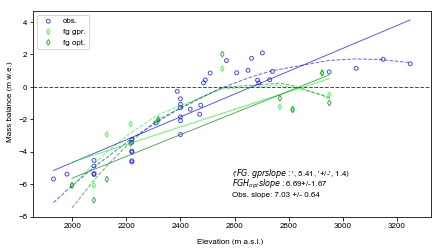

In [199]:
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize
yr = 2017#2016, 2017, 2018
a = 0.7
color=['b', 'lime', 'green']
dt = pd.read_csv('/home/pelto/Desktop/ice_flux/Conrad/Conrad_bdot.csv')
##all_obs
x_ax_obs=dt[(dt.Year==yr)].Elev
y_ax_obs=dt[(dt.Year==yr)].Ba_surv

##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()

new = new[new.b_fg_we >-8.]
new = new[new.b_fg_we_gpr >-8.]

x_ax_fg_gpr=new.elevmean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.elevmean   #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

for i in range(3):
    x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
    y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
    fit = np.polyfit(x[i],y[i],2)
    y_new = np.polyval(fit,x[i])
    ax.plot(x[i],y_new,c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

### observations of SMB
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x_ax_obs),np.array(y_ax_obs))
ax.scatter(x_ax_obs,y_ax_obs,color='b', label='obs.', alpha=a, s=s,facecolor='')
ax.plot(x_ax_obs,slope*x_ax_obs+intercept, color='b',label='', alpha=a, linewidth=0.9)

slopeG, interceptG, r_valueG, p_valueG, std_errG = stats.linregress(np.array(x_ax_fg_gpr),np.array(y_ax_fg_gpr))
ax.scatter(x_ax_fg_gpr,y_ax_fg_gpr,color='lime', label='fg gpr.', alpha=a, s=s,facecolor='', marker='d')
ax.plot(x_ax_fg_gpr,slopeG*x_ax_fg_gpr+interceptG, color='lime',label='', alpha=a, linewidth=0.9)

# X = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
# Y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
# out=[]
# for i in range(3):
#      ## X usually means our input variables (or independent variables)
#      ## Y usually means our output/dependent variable
#     X_new = stm.add_constant(X[i]) ## let's add an intercept (beta_0) to our model
#     mod = stm.OLS(Y[i], X_new).fit()   #FG_all.b_fg_we_gpr, FG_all._elevmean) # stm.OLS(output, input)
#     predictions = mod.predict(X_new)
#     out.append(np.round(1000*mod.bse[1],2) )





#         ### flux gate from GPR thickness
#         slopeM, interceptM, r_valueM, p_valueM, std_errM = stats.linregress(np.array(x_ax_fg),np.array(y_ax_fg))
#         ax.scatter(x_ax_fg,y_ax_fg,color='r', label='fgel', alpha=a, s=s+2, facecolor='')
#         ax.plot(x_ax_fg,slopeM*x_ax_fg+interceptM, color='r', label='', alpha=a, linewidth=0.9)
#         ax.text(0.5, 0.1, ['$obs. slope:$', np.round(slope,4)], transform=ax.transAxes)
#         ax.text(0.5, 0.2, ['$FG. slope:$', np.round(slopeM,4)], transform=ax.transAxes)

#         ax.text(0.05, 0.9, year[n], transform=ax.transAxes, fontweight='bold')

###flux gate from optimized thickness
slopeM_opt, interceptM_opt, r_valueM_opt, p_valueM_opt, std_errM_opt = stats.linregress(np.array(
    x_ax_fg_opt),np.array(y_ax_fg_opt))
ax.scatter(x_ax_fg_opt,y_ax_fg_opt,color='g', label='fg opt.', alpha=a, s=s+2, facecolor='', marker='d')
ax.plot(x_ax_fg_opt,slopeM_opt*x_ax_fg_opt+interceptM_opt, color='g', label='', alpha=a, linewidth=0.9)
ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)

# ax.text(0.05, 0.9, 'All', transform=ax.transAxes, fontweight='bold')
txt='Obs. slope: ' + str(np.round(1000*slope,2))+ ' +/- ' + str(np.round(1000*std_err,2))
# txtO=
# txtG=
ax.text(0.5, 0.1, txt, transform=ax.transAxes)
ax.text(0.5, 0.15, (str('$FG ' + 'H_{opt}''slope:$')+ str(np.round(1000*slopeM_opt,2))+ '+/-' + str(np.round(1000*std_errM_opt,2))), transform=ax.transAxes)
ax.text(0.5, 0.2, ('$FG. gpr slope:$', np.round(1000*slopeG,2),'+/-', np.round(1000*std_errG,2)), transform=ax.transAxes)
#'$\frac{+}{-}$'

fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.07, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='best')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
plt.savefig(fl_path + 'products/' + 'conrad_bdot_2017_new.png', dpi=300) #+ Glacier[gl]
plt.show()

In [229]:
obs

,ID,length,distance,angle,lon,lat,i,j,vx,vy,gpr,H_opt,dem
ij,,,,,,,,,,,,,
1429_1074,6,2297.359,0.0,119.223461,-116.944057,50.805831,1429,1074,9.381188,15.005661,1.000000,68.134018,2718.455078
1433_1076,6,2297.359,20.0,119.223461,-116.943810,50.805743,1433,1076,12.873265,14.693120,NaN,68.134018,2717.497070
1436_1078,6,2297.359,40.0,119.223461,-116.943562,50.805655,1436,1078,12.392245,13.185260,NaN,68.134018,2716.894531
1440_1080,6,2297.359,60.0,119.223461,-116.943314,50.805567,1440,1080,8.889536,9.348963,NaN,65.189636,2715.605469
1443_1082,6,2297.359,80.0,119.223461,-116.943067,50.805479,1443,1082,16.061119,13.717829,NaN,65.189636,2715.161865
1447_1084,6,2297.359,100.0,119.223461,-116.942819,50.805391,1447,1084,4.062439,8.723014,NaN,65.189636,2714.020752
1450_1086,6,2297.359,120.0,119.223461,-116.942572,50.805303,1450,1086,4.510988,6.673593,NaN,65.189636,2713.723145
1454_1088,6,2297.359,140.0,119.223461,-116.942324,50.805216,1454,1088,-0.069296,4.736941,NaN,59.816944,2712.239746
1457_1090,6,2297.359,160.0,119.223461,-116.942076,50.805128,1457,1090,-0.173039,3.683546,NaN,54.381569,2711.475342


/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


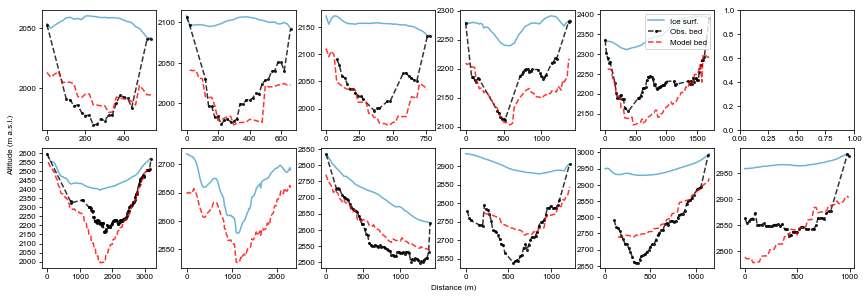

In [234]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs = df_agg.copy()
obs.gpr[obs.ID==6]=np.nan
obs = obs.dropna(subset=['gpr'])   #[obs.gpr != np.nan]


fig, ax = plt.subplots(2,6, figsize=(12,4))
for i in range(D.ID.nunique()):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.ID==i].distance, (df_agg[df_agg.ID==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs[obs.ID==i].dem)-(obs[obs.ID==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(obs[obs.ID==i].distance, gpr, marker='o'
                 , ms=2, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.ID_opt==i])-(df_agg[df_agg.ID_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    ax[j,k].plot(df_agg[df_agg.ID==i].distance, (df_agg[df_agg.ID==i].dem)-(df_agg[df_agg.ID==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50)) ##
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 5: 
        j += 1
        k = 0  
         
    ax[0,4].legend(loc=1)
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.05, right=0.99, wspace=0.22, hspace=0.15) 
plt.savefig(fl_path + 'products/' + 'Conrad_flux_gates_new.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.ID_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

range(0, 11)